# Model Creation and Training

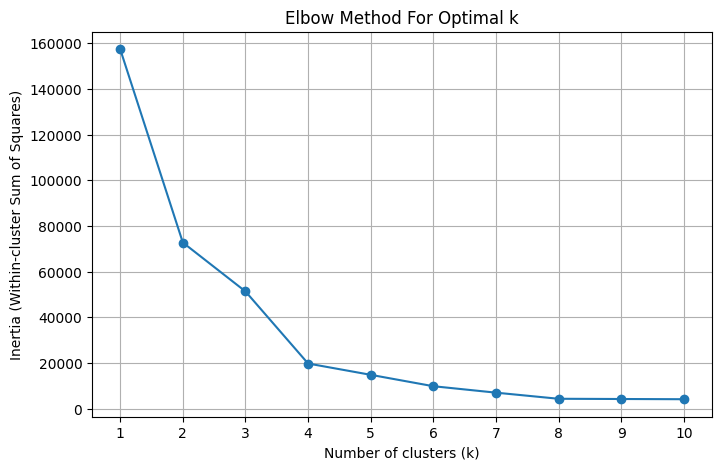

Optimal number of clusters based on the Elbow Method: k = 4


FileNotFoundError: [Errno 2] No such file or directory: 'attempt1.csv'

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator

#Assigning custom weights to each feature

features = columns_to_normalize = [
    "latitude",
    "longitude",
    "datetime_sin",
    "datetime_cos",
    "ElapsedTime",
    "MinWaitTime",
    "MaxWaitTime",
    "BagNumber",
    "MaxSpendingRange",
    "DropOffRange"
]

feature_weights = np.array([2.0, 2.0, 5.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0])

#testing normalized vs standard scalar
df_normalized = pd.read_csv("Synthetic_Data/normalized_synthetic_data.csv")
df_weighted_normalize = pd.DataFrame()

for i, feature in enumerate(features):
    df_weighted_normalize[feature] = df_normalized[feature] * feature_weights[i]

df_weighted_normalize.to_csv("Synthetic_Data/normalized_synthetic_data.csv", index=False)


# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
df_weighted_normalize['cluster'] = kmeans.fit_predict(df_weighted_normalize)

# Save the clustered dataset
df_weighted_normalize.to_csv("Synthetic_Data/clustered_flight_data.csv", index=False)

#Run K-means for k = 1 to 10 and store inertia
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit_predict(df_weighted_normalize)
    inertia.append(kmeans.inertia_)

# Step 2: Plot inertia vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Step 3: Automatically find the "elbow point"
kl = KneeLocator(k_range, inertia, curve="convex", direction="decreasing")
optimal_k = kl.elbow
print(f"Optimal number of clusters based on the Elbow Method: k = {optimal_k}")

# Step 4: Run final KMeans model using the optimal k
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_weighted_normalize['Cluster'] = final_kmeans.fit_predict(df_weighted_normalize.drop(columns='cluster'))



# Applying bag constraint clustering
def apply_bag_constraint_clustering(df, max_bag_sum=5):
    df_result = df.copy()
    
    # Add original BagNumber values if they're normalized
    if 'original_BagNumber' in df_normalized.columns:
        df_result['BagNumber_actual'] = df_normalized['original_BagNumber']
    else:
        # If we don't have original values, load them from the original file
        original_df = pd.read_csv('Synthetic_Data/attempt1.csv')
        df_result = df_result.reset_index(drop=True)
        original_df = original_df.reset_index(drop=True)
        df_result['BagNumber_actual'] = original_df['BagNumber']
    
    # First, get the clusters from KMeans results
    original_clusters = df_result['Cluster'].unique()
    
    # Initialize new cluster ID counter (starting after the max existing cluster ID)
    new_cluster_id = int(df_result['Cluster'].max()) + 1
# For each original cluster
    for cluster_id in original_clusters:
        # Get passengers in this cluster
        cluster_df = df_result[df_result['Cluster'] == cluster_id].copy()
        
        # Sort by bag number (descending) for better bin packing
        cluster_df = cluster_df.sort_values('BagNumber_actual', ascending=False)
        
        # Track which passengers have been reassigned
        reassigned = set()
        
        # Create new clusters satisfying the bag constraint
        current_sum = 0
        current_cluster = cluster_id  # Start with original cluster ID
        
        # Process each passenger
        for idx, row in cluster_df.iterrows():
            # If this passenger is already reassigned, skip
            if idx in reassigned:
                continue
                
            bag_count = row['BagNumber_actual']
            
            # If adding this passenger would exceed the limit, create a new cluster
            if current_sum + bag_count > max_bag_sum:
                current_cluster = new_cluster_id
                new_cluster_id += 1
                current_sum = 0
            
            # Assign to current cluster and update sum
            df_result.loc[idx, 'Cluster'] = current_cluster
            current_sum += bag_count
            reassigned.add(idx)
    
    # Add a column with the total bag count per cluster
    df_result['ClusterBagSum'] = df_result.groupby('Cluster')['BagNumber_actual'].transform('sum')
    
    return df_result

# Apply bag constraint to recluster
df_constrained = pd.DataFrame()
df_constrained = apply_bag_constraint_clustering(df_weighted_normalize, max_bag_sum=5)

# Save the new clustered dataset
df_constrained.to_csv("Synthetic_Data/bag_constrained_clusters.csv", index=False)

# Analyze the results
cluster_stats = df_constrained.groupby('Cluster').agg({
    'BagNumber_actual': ['count', 'sum', 'mean'],
    'MaxSpendingRange': 'mean',
    'DropOffRange': 'mean'
})

print(f"Number of clusters after applying bag constraint: {df_constrained['Cluster'].nunique()}")
print("\nCluster statistics:")
print(cluster_stats)




In [2]:
import altair as alt
import pandas as pd

alt.data_transformers.disable_max_rows()


# Load clustered data
df = pd.read_csv("clustered_flight_data.csv")

df['cluster'] = df['cluster'].astype(str)

# Select 2D features for the plot (you can switch to PCA/t-SNE later)
x_feature = 'ElapsedTime'
y_feature = 'latitude'

# Build the interactive plot
chart = alt.Chart(df).mark_circle(size=60).encode(
    x=alt.X(x_feature, title=x_feature),
    y=alt.Y(y_feature, title=y_feature),
    color=alt.Color('cluster:N', title='Cluster'),
    tooltip=[
        'cluster:N',
        'latitude', 'longitude',
        'datetime_sin', 'datetime_cos',
        'ElapsedTime', 'MinWaitTime', 'MaxWaitTime',
        'BagNumber', 'MaxSpendingRange', 'DropOffRange'
    ]
).properties(
    title=f'Clusters Visualized: {x_feature} vs {y_feature}',
    width=700,
    height=500
).interactive()

chart


alt.Chart(...)